In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter 

## Data Processing

In [3]:
class AnnotationProcessor:
    def __init__(self, base_path, output_path='/kaggle/working/', filename='dataset.csv'):
        self.base_path = base_path
        self.output_path = output_path
        self.filename = filename
        self.data = None
        self.run()

    def get_group_annotation(self, file, folder_name):
        """Extract the first two elements from each row of the annotation file."""
        with open(file, 'r') as f:
            data = [line.split()[:2] for line in f]

        df = pd.DataFrame(data, columns=['FrameID', 'Label'])
        df['video_names'] = folder_name
## ['l-spike', 'l_set', 'r_set', 'r-pass', 'r_spike', 'l-pass',
       #'r_winpoint', 'l_winpoint']
        label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}
        df['Mapped_Label'] = df['Label'].map(label_mapping).astype('int64')
        # Ensure the output directory exists
        os.makedirs(self.output_path, exist_ok=True)
        # Save the file directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, f'{folder_name}.csv'), index=False)

    def process_annotations(self):
        """Process annotations from all folders in the base path."""
        for folder_name in os.listdir(self.base_path):
            folder_path = os.path.join(self.base_path, folder_name)
            if os.path.isdir(folder_path):
                annotated_file_path = os.path.join(folder_path, 'annotations.txt')
                self.get_group_annotation(annotated_file_path, folder_name)

    def combine_csv_files(self):
        """Combine all CSV files into a single DataFrame."""
        csv_files = glob.glob(os.path.join(self.output_path, '*.csv'))
        data = [pd.read_csv(csv_file) for csv_file in csv_files]
        for d in data:
            d.dropna(inplace=True)
            # print(d.isna().sum())
        return pd.concat(data, ignore_index=True)

    def generate_img_paths(self, df):
        """Generate image paths based on the DataFrame."""
        df['img_path'] = df.apply(
            lambda x: os.path.join(
                self.base_path,
                str(x['video_names']),  # Ensure `video_names` is a string
                str(x['FrameID'])[:-4],  # Ensure `FrameID` is a string and remove the last 4 characters
                str(x['FrameID'])  # Ensure `FrameID` is a string
            ), axis=1
        )
        return df

    def save_combined_data(self, df):
        """Save the combined data to a CSV file."""
        # Ensure the output directory exists before saving
        os.makedirs(self.output_path, exist_ok=True)
        # Save the combined data directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, self.filename), index=False)

    def cleanup(self):
        """Delete all intermediate CSV files except the final output file."""
        for csv_file in glob.glob(os.path.join(self.output_path, '*.csv')):
            if not csv_file.endswith(self.filename):
                os.remove(csv_file)

    def run(self):
        """Run the whole annotation processing pipeline."""
        self.process_annotations()
        combined_data = self.combine_csv_files()
        data_with_paths = self.generate_img_paths(combined_data)
        self.save_combined_data(data_with_paths)
        self.cleanup()  # Clean up intermediate files
        self.data = pd.read_csv(os.path.join(self.output_path, self.filename))


Make sure you want to run this before running it

In [3]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [4]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = AnnotationProcessor(base_path, 'dataset.csv').data

## Model

In [5]:
class ResnetEvolution(nn.Module):
    def __init__(self, hidden_layers=[128, 64, 32]):
        super(ResnetEvolution, self).__init__()
        self.hidden_layers = hidden_layers
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features

        layers = []
        input_size = num_features  # Start with backbone output size
        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            input_size = hidden_size  # Update input for next layer

        layers.append(nn.Linear(input_size, 8))  # Final output layer

        backbone.fc = nn.Sequential(*layers)  # Output layer for binary classification

        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Trainer

In [23]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, scheduled, criterion, epochs, dataloaders, device, save_folder, is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduled = scheduled
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint

    #verbose 1 : checkpoint,
    #verbose 3:  labels, preds
    #verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders

        epoch = 0
        if self.is_continue:

            if verbose>0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            # print(f"\nTraining epoch {training_epoch}: training {'full model' if self.__check_transfer_learning(training_epoch/epochs) else 'only fc model'}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    model.train()
                    for inputs, labels in tqdm(dataloader, desc=phase):

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        # forward pass
                        logit = model(inputs)

                        if verbose > 3:
                            print(f"logit: {logit}")

                        loss = criterion(logit, labels)
                        loss.backward()
                        # update weights
                        optimizer.step()
                        epoch_loss += loss.item()  # Accumulate loss
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    print(f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss

            if self.scheduled:
                optimizer.scheduler_step()
                self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.optimizer_state_dict(), optimizer.scheduler_state_dict(), verbose)
            else:
                self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(), verbose)

        self.__save_model(verbose)

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs = inputs.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                if verbose > 2:
                    print(f"labels: {labels}")

                # Forward pass
                logits = model(inputs)

                if verbose > 3:
                    print(f"logit: {logits}")

                probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                if verbose > 3:
                    print(f"probs: {probs}")

                loss = criterion(logits, labels)
                val_loss += loss.item()  # Accumulate loss

                # Compute accuracy
                predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                if verbose > 2:
                    print(f"predicted: {predicted}")
                    print(f"true/false: {(predicted == labels)}")

                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

    def __save_model(self, verbose=0):
        torch.save(self.model.state_dict(), self.save_folder + "/b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {self.save_folder}/b1_model.pth")

    def __save_checkpoint(self, epoch, model_state_dict, optimizer_state_dict, scheduler_state_dict=None, verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'scheduler_state_dict': scheduler_state_dict
        }
        torch.save(checkpoint, self.save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {self.save_folder}/checkpoint-epoch{epoch}.pth')

    def __load_checkpoint(self, model, optimizer, checkpoint_path, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        scheduler_state_dict = checkpoint['scheduler_state_dict']
        model = model.load_state_dict(model_state_dict)
        if self.scheduled:
            optimizer.load_state_dict(optimizer_state_dict, scheduler_state_dict)
        else:
            optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Dataset

In [7]:
class B1Dataset(Dataset):

    VIDEO_SPLITS = {
        'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
        'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
        'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
    }

    def __init__(self, csv_file, split='train', transform=None):
        self.data = pd.read_csv(csv_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        if split in self.VIDEO_SPLITS:
            self.data = self.data[self.data['video_names'].astype(int).isin(self.VIDEO_SPLITS[split])]
        else:
            raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['img_path']
        label = self.data.iloc[idx]['Mapped_Label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

## Loss

In [8]:
class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, dataset, device):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.dataset = dataset
        self.device = device
        weight = self.__compute_weights()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def __compute_weights(self):
        print('Computing weights...')
        label_counts = Counter([label.item() for _, label in self.dataset])
        total_samples = len(self.dataset)

        class_weights = [total_samples / label_counts[i] if i in label_counts else 0 for i in range(8)]

        weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        print('Weights computed.')
        return weights

    def forward(self, logit, target):
        return self.loss(logit, target)

## Optimizer

In [21]:
import torch
import torch.optim as optim

class AdamWScheduled():
    def __init__(self, model_params, lr, step_size, gamma):
        self.optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_params),  lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma)

    def step(self):
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def scheduler_step(self):
        self.scheduler.step()

    def optimizer_state_dict(self):
        return self.optimizer.state_dict()

    def scheduler_state_dict(self):
        return self.scheduler.state_dict()
    
    def load_state_dict(self, optimizer_state_dict, scheduler_state_dict):
        self.optimizer.load_state_dict(optimizer_state_dict)
        self.scheduler.load_state_dict(scheduler_state_dict)

## Code

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256     
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomRotation(degrees=5),                   # Randomly rotate images within ±5 degrees
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='train', transform=train_transform)
val_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='val')

In [15]:
batch_size = 150
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

In [12]:
!mkdir '/kaggle/working/checkpoints/'

In [24]:
criterion = WeightedCrossEntropyLoss(train_dataset, device)

Computing weights...
Weights computed.


In [25]:
model = ResnetEvolution(hidden_layers=[])
model = model.to(device)
optimizer = AdamWScheduled(model_params=model.parameters(), lr=0.001, step_size=10, gamma=0.1)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer,True, criterion, epochs=20, dataloaders=dataloaders, device=device, save_folder=save_folder)

In [26]:
trainer.train_model()

train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 1/20, train Loss: 1.884643292427063


Evaluating: 100%|██████████| 9/9 [00:22<00:00,  2.54s/it]


Epoch 1/20, (val) Loss: 2.514511081907484 | Accuracy: 0.28560775540641314


train: 100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


Epoch 2/20, train Loss: 1.417041818300883


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


Epoch 2/20, (val) Loss: 2.014378799332513 | Accuracy: 0.3862788963460104


train: 100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


Epoch 3/20, train Loss: 1.2037887096405029


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


Epoch 3/20, (val) Loss: 2.281111200650533 | Accuracy: 0.3668903803131991


train: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Epoch 4/20, train Loss: 1.1190539280573526


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]


Epoch 4/20, (val) Loss: 2.2094474103715687 | Accuracy: 0.36838180462341535


train: 100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


Epoch 5/20, train Loss: 1.0626222928365072


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.33s/it]


Epoch 5/20, (val) Loss: 0.9967798789342245 | Accuracy: 0.6010439970171514


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 6/20, train Loss: 0.9459997932116191


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 6/20, (val) Loss: 2.894162734349569 | Accuracy: 0.2721849366144668


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 7/20, train Loss: 0.9545263846715292


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 7/20, (val) Loss: 1.1440698901812236 | Accuracy: 0.5384041759880686


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 8/20, train Loss: 0.8604709347089131


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


Epoch 8/20, (val) Loss: 0.9111261566480001 | Accuracy: 0.6711409395973155


train: 100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


Epoch 9/20, train Loss: 0.8335743308067322


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


Epoch 9/20, (val) Loss: 0.9787568847338358 | Accuracy: 0.668903803131991


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 10/20, train Loss: 0.7717549482981364


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


Epoch 10/20, (val) Loss: 1.0216450889905293 | Accuracy: 0.6428038777032066


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 11/20, train Loss: 0.7000360568364461


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 11/20, (val) Loss: 0.7983015908135308 | Accuracy: 0.7024608501118568


train: 100%|██████████| 15/15 [00:48<00:00,  3.22s/it]


Epoch 12/20, train Loss: 0.6255517562230428


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]


Epoch 12/20, (val) Loss: 0.7893152899212308 | Accuracy: 0.7099179716629381


train: 100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


Epoch 13/20, train Loss: 0.6246822079022726


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Epoch 13/20, (val) Loss: 0.7784819801648458 | Accuracy: 0.7203579418344519


train: 100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


Epoch 14/20, train Loss: 0.5876984973748525


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]


Epoch 14/20, (val) Loss: 0.7682655718591478 | Accuracy: 0.7240865026099925


train: 100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


Epoch 15/20, train Loss: 0.592297883828481


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


Epoch 15/20, (val) Loss: 0.820922957526313 | Accuracy: 0.7121551081282624


train: 100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


Epoch 16/20, train Loss: 0.5873933474222819


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


Epoch 16/20, (val) Loss: 0.7911642260021634 | Accuracy: 0.7233407904548844


train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 17/20, train Loss: 0.5749281446139017


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


Epoch 17/20, (val) Loss: 0.77995855278439 | Accuracy: 0.7173750932140194


train: 100%|██████████| 15/15 [00:46<00:00,  3.07s/it]


Epoch 18/20, train Loss: 0.5510039091110229


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 18/20, (val) Loss: 0.7950643433464898 | Accuracy: 0.7106636838180462


train: 100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


Epoch 19/20, train Loss: 0.5217907269795735


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.24s/it]


Epoch 19/20, (val) Loss: 0.785742806063758 | Accuracy: 0.7196122296793438


train: 100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


Epoch 20/20, train Loss: 0.5330451548099517


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


Epoch 20/20, (val) Loss: 0.7486531403329637 | Accuracy: 0.7300521998508576


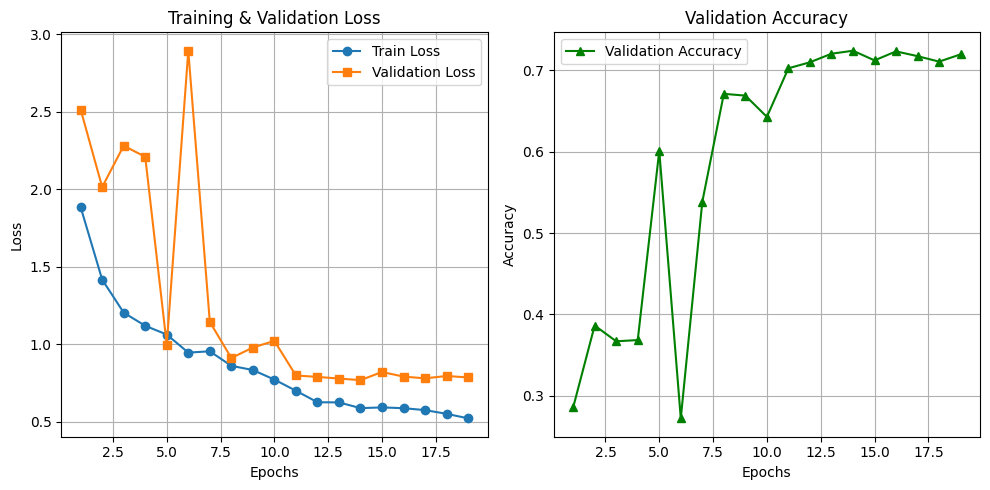

In [28]:
import matplotlib.pyplot as plt

# Loss values
train_loss = [
    1.8846, 1.4170, 1.2038, 1.1191, 1.0626, 0.9460, 0.9545, 0.8605, 0.8336, 0.7718,
    0.7000, 0.6256, 0.6247, 0.5877, 0.5923, 0.5874, 0.5749, 0.5510, 0.5218
]
val_loss = [
    2.5145, 2.0144, 2.2811, 2.2094, 0.9968, 2.8942, 1.1441, 0.9111, 0.9788, 1.0216,
    0.7983, 0.7893, 0.7785, 0.7683, 0.8209, 0.7912, 0.7800, 0.7951, 0.7857
]
accuracy = [
    0.2856, 0.3863, 0.3669, 0.3684, 0.6010, 0.2722, 0.5384, 0.6711, 0.6689, 0.6428,
    0.7025, 0.7099, 0.7204, 0.7241, 0.7122, 0.7233, 0.7174, 0.7107, 0.7196
]

epochs = list(range(1, len(train_loss) + 1))

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Validation Accuracy', marker='^', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()